# Kaggle 집 가격 예측 - 회귀

## 초기 세팅

In [ ]:
# Afrom google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Kaggle 팀 과제/집 가격 예측(회귀)'
path = '/content/gdrive/MyDrive/Kaggle 팀 과제/집 가격 예측(회귀)'
!ls

In [ ]:
!unzip -o -qq regression220718.zip

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 로드

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
# 제출 시 필요한 ID 저장
test_id_idx = sample_submission['ID']

In [ ]:
test_id_idx

0        18510
1        18511
2        18512
3        18513
4        18514
         ...  
15141    33651
15142    33652
15143    33653
15144    33654
15145    33655
Name: ID, Length: 15146, dtype: int64

In [ ]:
# 훈련, 테스트 데이터 크기 저장
len_train_df = len(train_df)
len_test_df = len(test_df)

In [ ]:
train_df.head()

## 결측치 처리

In [ ]:
# 결측치 0으로 처리
train_df['GARAGE'].fillna(0, inplace = True)
test_df['GARAGE'].fillna(0, inplace = True)

## 데이터 전처리 및 특징 생성

In [ ]:
# 판매 연도를 사용하기 위해 DATE_SOLD 컬럼을 SOLD_MONTH 와 SOLD_YEAR로 분리 (ex/ 09-2015 -> 09 | 2015)
train_df[['SOLD_MONTH', 'SOLD_YEAR']] = train_df['DATE_SOLD'].str.split('-', 1, expand=True).astype('float64')
train_df.drop(['DATE_SOLD'],axis=1,inplace=True)

test_df[['SOLD_MONTH', 'SOLD_YEAR']] = test_df['DATE_SOLD'].str.split('-', 1, expand=True).astype('float64')
test_df.drop(['DATE_SOLD'],axis=1,inplace=True)

In [ ]:
# 건물이 지어지기 전에 먼저 팔린 집들을 특징으로 추출(PRESOLD)
train_df['PRESOLD'] = train_df['SOLD_YEAR'].astype('int') < train_df['BUILD_YEAR']
test_df['PRESOLD'] = test_df['SOLD_YEAR'].astype('int') < test_df['BUILD_YEAR']

In [ ]:
# 방 하나당 면적 특징 생성
# train_df['ROOM_PER_FLOOR'] = train_df['FLOOR_AREA'] / (train_df['BEDROOMS'] + train_df['BATHROOMS'] + train_df['GARAGE'])
# test_df['ROOM_PER_FLOOR'] = test_df['FLOOR_AREA'] / (test_df['BEDROOMS'] + test_df['BATHROOMS'] + test_df['GARAGE'])

In [ ]:
# 이상치 제거
# train_df['NEAREST_SCH_DIST'][train_df['NEAREST_SCH_DIST'] > 10.5] = 10.5
# test_df['NEAREST_SCH_DIST'][test_df['NEAREST_SCH_DIST'] > 10.5] = 10.5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# LAND_AREA에서 1200을 기준으로 특징 생성
# train_df['SMLLAND'] = train_df['LAND_AREA'] < 1200
# train_df['BIGLAND'] = train_df['LAND_AREA'] >= 1200
# test_df['SMLLAND'] = test_df['LAND_AREA'] < 1200
# test_df['BIGLAND'] = test_df['LAND_AREA'] >= 1200

In [ ]:
# 근처 역이 Midland Station인지 아닌지를 특징으로 생성
# train_df['Is_Midland Station'] = train_df['NEAREST_STN'] == 'Midland Station'
# test_df['Is_Midland Station'] = test_df['NEAREST_STN'] == 'Midland Station'

In [ ]:
# 의미없는 특징 제거
train_df.drop(['ID', 'ADDRESS', 'SUBURB', 'SOLD_MONTH', 'NEAREST_SCH'], axis = 1, inplace = True)

In [ ]:
# 결측치 최빈값 처리
# train_df.loc[4115,'LAND_AREA'] = 375 # m^2
# train_df.loc[14806,'LAND_AREA'] = 375
# train_df.loc[12373,'LAND_AREA'] = 574 
# train_df.loc[11523,'LAND_AREA'] = 375 # m^2

In [ ]:
# PRICE와 상관관계가 0.01이상인 특징들만 추출
corrmat = train_df.corr()
top_corr_features = corrmat.index[abs(corrmat["PRICE"])>=0.01]
top_corr_features

Index(['PRICE', 'BEDROOMS', 'BATHROOMS', 'GARAGE', 'LAND_AREA', 'FLOOR_AREA',
       'BUILD_YEAR', 'CBD_DIST', 'NEAREST_STN_DIST', 'POSTCODE', 'LATITUDE',
       'LONGITUDE', 'NEAREST_SCH_DIST', 'NEAREST_SCH_RANK', 'SOLD_YEAR',
       'PRESOLD'],
      dtype='object')

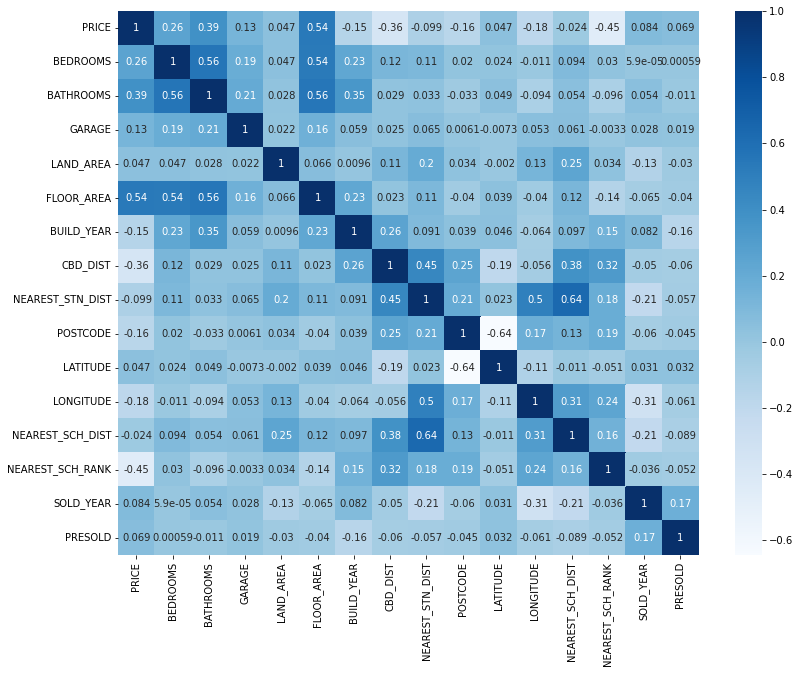

In [ ]:
# 상관관계 시각화
plt.figure(figsize=(13,10))
g = sns.heatmap(train_df[top_corr_features].corr(),annot=True,cmap="Blues")

In [ ]:
# feature selection
train_df = train_df[top_corr_features]
test_df = test_df[train_df.columns.drop(['PRICE'])]

In [ ]:
# 테스트 데이터 정답 제거
test_df = test_df[train_df.columns.drop(['PRICE'])]

In [ ]:
train_y_label = train_df['PRICE'] 	# target 값을 미리 분리하였음.
train_df.drop(['PRICE'], axis=1, inplace=True)

In [ ]:
# 특징 중요도 파악을 위한 xgboost 모델 학습
import xgboost as xgb

model_xgb = xgb.XGBRegressor(eta = 0.1, n_estimators = 650, colsample_bylevel = 0.7, colsample_bytree = 0.7, max_depth = 5, seed = 42)
model_xgb.fit(train_df, train_y_label)

[10:32:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bylevel=0.7, colsample_bytree=0.7, eta=0.1, max_depth=5,
             n_estimators=650, seed=42)

In [ ]:
# 특징 중요도 계산
importance = model_xgb.feature_importances_

In [ ]:
# 특징 중요도 데이터 프레임화
importances = pd.DataFrame()

In [ ]:
# 특징 중요도 확인
importances['feature'] = train_df.columns
importances['importances'] = importance
importances.sort_values('importances', ascending=False, inplace=True)
importances.reset_index(drop=True, inplace=True)
importances

,feature,importances
0,NEAREST_SCH_RANK,0.196100
1,PRESOLD,0.122488
2,BATHROOMS,0.107791
3,POSTCODE,0.103984
4,SMLLAND,0.077898
5,FLOOR_AREA,0.072219
6,BIGLAND,0.069498
7,BEDROOMS,0.051780
8,CBD_DIST,0.050108
9,SOLD_YEAR,0.035742


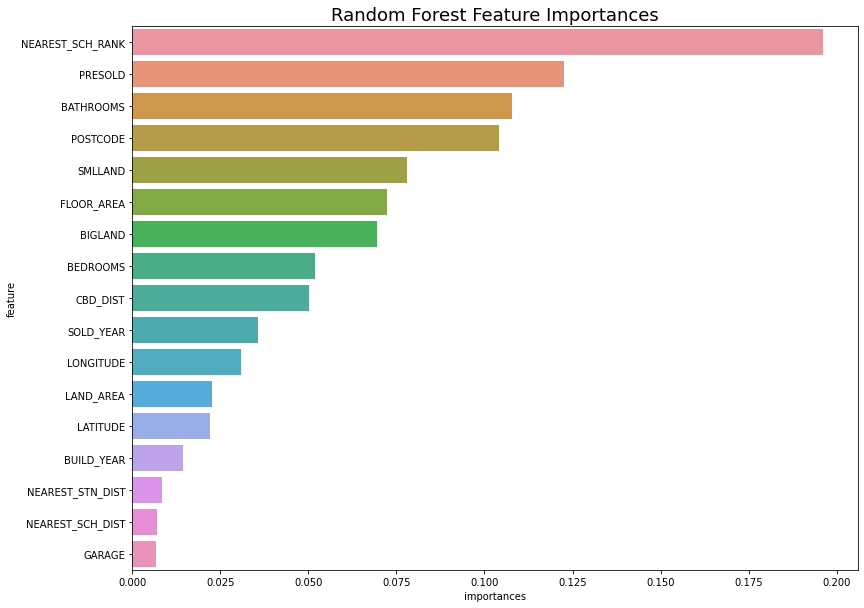

In [ ]:
# 특징 중요도 시각화
plt.figure(figsize=(13,10))
sns.barplot(x='importances', y='feature', data= importances)
plt.title('Random Forest Feature Importances', fontsize=18)
plt.show()

In [ ]:
# 전처리를 위해 잠시 concat
boston_df = pd.concat((train_df, test_df), axis=0)
boston_df_index = boston_df.index

print('Length of Boston Dataset : ',len(boston_df))
boston_df.head()

Length of Boston Dataset :  33656


,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH_DIST,NEAREST_SCH_RANK,SOLD_YEAR,PRESOLD
0,5,2,4.0,674,266,2007.0,35500,3000,6030,-31.656206,115.720566,1.079230,120.0,2015.0,True
1,5,4,2.0,540,301,2014.0,16900,8100,6065,-31.800802,115.867675,0.667585,NaN,2018.0,True
2,4,2,2.0,781,220,1992.0,33500,3500,6030,-31.682040,115.702600,0.650761,111.0,2020.0,True
3,2,1,2.0,425,185,1938.0,3500,1500,6016,-31.926046,115.838181,0.484465,106.0,2020.0,True
4,3,2,2.0,546,186,2004.0,12900,800,6159,-32.032079,115.759626,1.869050,25.0,2017.0,True


In [ ]:
# check null 
check_null = boston_df.isna().sum() / len(boston_df)

# columns of null ratio >= 0.5
check_null[check_null >= 0.0]

BEDROOMS            0.000000
BATHROOMS           0.000000
GARAGE              0.000000
LAND_AREA           0.000000
FLOOR_AREA          0.000000
BUILD_YEAR          0.093743
CBD_DIST            0.000000
NEAREST_STN_DIST    0.000000
POSTCODE            0.000000
LATITUDE            0.000000
LONGITUDE           0.000000
NEAREST_SCH_DIST    0.000000
NEAREST_SCH_RANK    0.325410
SOLD_YEAR           0.000000
PRESOLD             0.000000
dtype: float64

In [ ]:
# split object & numeric
boston_obj_df = boston_df.select_dtypes(include='object')	# 카테고리형
boston_num_df = boston_df.select_dtypes(exclude='object')	# 수치형

In [ ]:
print('Object type columns:\n',boston_obj_df.columns)
print('---------------------------------------------------------------------------------')
print('Numeric type columns:\n',boston_num_df.columns)

Object type columns:
 Index([], dtype='object')
---------------------------------------------------------------------------------
Numeric type columns:
 Index(['BEDROOMS', 'BATHROOMS', 'GARAGE', 'LAND_AREA', 'FLOOR_AREA',
       'BUILD_YEAR', 'CBD_DIST', 'NEAREST_STN_DIST', 'POSTCODE', 'LATITUDE',
       'LONGITUDE', 'NEAREST_SCH_DIST', 'NEAREST_SCH_RANK', 'SOLD_YEAR',
       'PRESOLD'],
      dtype='object')


In [ ]:
# boston_dummy_df = pd.get_dummies(boston_obj_df, drop_first=True)
# boston_dummy_df.index = boston_df_index
# boston_dummy_df.head()
# boston_dummy_df = pd.DataFrame()

# from sklearn.preprocessing import LabelEncoder
# for col in boston_obj_df.columns:
#     le = LabelEncoder()
#     le.fit(boston_obj_df[col])
#     boston_dummy_df[col] = le.transform(boston_obj_df[col])


In [ ]:
# 결측치 평균값으로 처리
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
imputer.fit(boston_num_df)
boston_num_df_ = imputer.transform(boston_num_df)
boston_num_df = pd.DataFrame(boston_num_df_, columns=boston_num_df.columns, index=boston_df_index )
boston_num_df.head()

,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH_DIST,NEAREST_SCH_RANK,SOLD_YEAR,PRESOLD
0,5.0,2.0,4.0,674.0,266.0,2007.0,35500.0,3000.0,6030.0,-31.656206,115.720566,1.079230,120.000000,2015.0,1.0
1,5.0,4.0,2.0,540.0,301.0,2014.0,16900.0,8100.0,6065.0,-31.800802,115.867675,0.667585,72.672569,2018.0,1.0
2,4.0,2.0,2.0,781.0,220.0,1992.0,33500.0,3500.0,6030.0,-31.682040,115.702600,0.650761,111.000000,2020.0,1.0
3,2.0,1.0,2.0,425.0,185.0,1938.0,3500.0,1500.0,6016.0,-31.926046,115.838181,0.484465,106.000000,2020.0,1.0
4,3.0,2.0,2.0,546.0,186.0,2004.0,12900.0,800.0,6159.0,-32.032079,115.759626,1.869050,25.000000,2017.0,1.0


In [ ]:
# 특징 제곱
square_df = boston_num_df ** 2
square_df.drop(['PRESOLD'], axis = 1, inplace = True)
square_df.columns = ['BEDROOMS2', 'BATHROOMS2', 'GARAGE2', 'LAND_AREA2', 'FLOOR_AREA2',
       'BUILD_YEAR2', 'CBD_DIST2', 'NEAREST_STN_DIST2', 'POSTCODE2', 'LATITUDE2',
       'LONGITUDE2', 'NEAREST_SCH_DIST2', 'NEAREST_SCH_RANK2', 'SOLD_YEAR2']

In [ ]:
# 특징 세제곱
triple_df = boston_num_df ** 3
triple_df.drop(['PRESOLD'], axis = 1, inplace = True)
triple_df.columns = ['BEDROOMS3', 'BATHROOMS3', 'GARAGE3', 'LAND_AREA3', 'FLOOR_AREA3',
       'BUILD_YEAR3', 'CBD_DIST3', 'NEAREST_STN_DIST3', 'POSTCODE3', 'LATITUDE3',
       'LONGITUDE3', 'NEAREST_SCH_DIST3', 'NEAREST_SCH_RANK3', 'SOLD_YEAR3']

In [ ]:
# quadra_df = boston_num_df ** 4
# quadra_df.drop(['PRESOLD', 'SMLLAND', 'BIGLAND'], axis = 1, inplace = True)
# quadra_df.columns = ['BEDROOMS4', 'BATHROOMS4', 'GARAGE4', 'LAND_AREA4', 'FLOOR_AREA4',
#        'BUILD_YEAR4', 'CBD_DIST4', 'NEAREST_STN_DIST4', 'POSTCODE4', 'LATITUDE4',
#        'LONGITUDE4', 'NEAREST_SCH_DIST4', 'NEAREST_SCH_RANK4', 'SOLD_YEAR4']

In [ ]:
# boston_df = pd.concat([boston_num_df, square_df], axis = 1)

In [ ]:
# 생성한 특징 concat
boston_num_df = pd.concat([boston_num_df, square_df, triple_df], axis = 1)

In [ ]:
# numeric & categorical concat
boston_df = pd.concat([boston_obj_df, boston_num_df], axis = 1)

In [ ]:
boston_df

,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,POSTCODE,LATITUDE,...,FLOOR_AREA3,BUILD_YEAR3,CBD_DIST3,NEAREST_STN_DIST3,POSTCODE3,LATITUDE3,LONGITUDE3,NEAREST_SCH_DIST3,NEAREST_SCH_RANK3,SOLD_YEAR3
0,5.0,2.0,4.0,674.0,266.0,2007.0,35500.0,3000.0,6030.0,-31.656206,...,18821096.0,8.084294e+09,4.473888e+13,2.700000e+10,2.192562e+11,-31723.170852,1.549643e+06,1.257020,1.728000e+06,8.181353e+09
1,5.0,4.0,2.0,540.0,301.0,2014.0,16900.0,8100.0,6065.0,-31.800802,...,27270901.0,8.169179e+09,4.826809e+12,5.314410e+11,2.230963e+11,-32159.866136,1.555560e+06,0.297522,3.838058e+05,8.217950e+09
2,4.0,2.0,2.0,781.0,220.0,1992.0,33500.0,3500.0,6030.0,-31.682040,...,10648000.0,7.904383e+09,3.759538e+13,4.287500e+10,2.192562e+11,-31800.900197,1.548921e+06,0.275591,1.367631e+06,8.242408e+09
3,2.0,1.0,2.0,425.0,185.0,1938.0,3500.0,1500.0,6016.0,-31.926046,...,6331625.0,7.278826e+09,4.287500e+10,3.375000e+09,2.177326e+11,-32541.336727,1.554373e+06,0.113707,1.191016e+06,8.242408e+09
4,3.0,2.0,2.0,546.0,186.0,2004.0,12900.0,800.0,6159.0,-32.032079,...,6434856.0,8.048096e+09,2.146689e+12,5.120000e+08,2.336311e+11,-32866.644403,1.551213e+06,6.529243,1.562500e+04,8.205739e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15141,3.0,1.0,0.0,801.0,108.0,1996.0,10800.0,3900.0,6061.0,-31.857800,...,1259712.0,7.952096e+09,1.259712e+12,5.931900e+10,2.226552e+11,-32333.099925,1.554219e+06,2.476244,3.838058e+05,8.217950e+09
15142,4.0,2.0,2.0,530.0,158.0,1998.0,13100.0,854.0,6147.0,-32.039400,...,3944312.0,7.976024e+09,2.248091e+12,6.228359e+08,2.322681e+11,-32889.185888,1.558946e+06,3.554737,3.838058e+05,8.217950e+09
15143,3.0,2.0,2.0,1072.0,148.0,1950.0,14700.0,3800.0,6020.0,-31.852980,...,3241792.0,7.414875e+09,3.176523e+12,5.487200e+10,2.181672e+11,-32318.426411,1.551108e+06,5.637822,1.038230e+05,8.181353e+09
15144,5.0,3.0,2.0,19996.0,396.0,1990.0,24900.0,10200.0,6071.0,-31.878930,...,62099136.0,7.880599e+09,1.543825e+13,1.061208e+12,2.237591e+11,-32397.478348,1.565245e+06,43.760149,4.745520e+05,8.144866e+09


In [ ]:
# train, test 셋으로 다시 분리
train_df = boston_df[:-len_test_df]
test_df = boston_df[-len_test_df:]

In [ ]:
# 원핫 인코딩
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
# fit_transform은 train에만 사용하고 test에는 학습된 인코더에 fit만 해야한다
train_dummy_df = ohe.fit_transform(train_df[['NEAREST_STN']])
train_dummy_df = pd.DataFrame(train_dummy_df, columns=['NEAREST_STN_' + col for col in ohe.categories_[0]])

In [ ]:
test_dummy_df = ohe.transform(test_df[['NEAREST_STN']])
test_dummy_df = pd.DataFrame(test_dummy_df, columns=['NEAREST_STN_' + col for col in ohe.categories_[0]])

In [ ]:
# 원핫 인코딩한 데이터프레임 merge
train_df = pd.merge(train_df, train_dummy_df, left_index = True, right_index = True)
test_df = pd.merge(test_df, test_dummy_df, left_index = True, right_index = True)

In [ ]:
# StandardScaler로 스케일링
# from sklearn.preprocessing import StandardScaler
# std_scaler = StandardScaler()
# std_scaler.fit(train_df)
# train_df = std_scaler.transform(train_df)
# train_df = pd.DataFrame(train_df, columns = boston_df.columns)

# std_scaler.fit(test_df)
# test_df = std_scaler.transform(test_df)
# test_df = pd.DataFrame(test_df, columns = boston_df.columns)

## 모델 학습 준비

In [ ]:
# 학습 데이터 정답(PRICE)과 분리

train_df['PRICE'] = train_y_label

print('train set length: ',len(train_df))
print('test set length: ',len(test_df))


from sklearn.model_selection import train_test_split

X_train = train_df.drop(['PRICE'], axis=1)
y_train = train_df['PRICE']

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state = 42)

X_test = test_df

train set length:  18510
test set length:  15146


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# from sklearn.preprocessing import PolynomialFeatures

# poly_features = PolynomialFeatures(degree=3, include_bias=False) # 기본 다항식형태를 만들고
# x_poly = poly_features.fit_transform(X_train)

In [ ]:
# corrmat = train_df.corr()
# top_corr_features = corrmat.index[abs(corrmat["PRICE"])>=0.01]
# top_corr_features

Index(['BEDROOMS', 'BATHROOMS', 'GARAGE', 'LAND_AREA', 'FLOOR_AREA',
       'BUILD_YEAR', 'CBD_DIST', 'NEAREST_STN_DIST', 'POSTCODE', 'LATITUDE',
       ...
       'NEAREST_STN_Swanbourne Station', 'NEAREST_STN_Thornlie Station',
       'NEAREST_STN_Vic', 'NEAREST_STN_Warnbro Station',
       'NEAREST_STN_Warwick Station', 'NEAREST_STN_Wellard Station',
       'NEAREST_STN_Welshpool Station', 'NEAREST_STN_West Leederville Station',
       'NEAREST_STN_Woodbridge Station', 'PRICE'],
      dtype='object', length=103)

In [ ]:
# feature selection
train_df = train_df[top_corr_features]
test_df = test_df[train_df.columns.drop(['PRICE'])]

In [ ]:
# target값 분리
X_train = train_df.drop(['PRICE'], axis=1)
y_train = train_df['PRICE']

In [ ]:
train_y_label = train_df['PRICE'] 	# target 값을 미리 분리하였음.
train_df.drop(['PRICE'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# 캣부스트 사용을 위해 catboost 설치
# !pip install catboost

## 모델 학습

In [ ]:
# catboost 회귀모델 학습
from catboost import CatBoostRegressor

model = CatBoostRegressor()
model.fit(X_train, y_train)

Learning rate set to 0.064928
0:	learn: 340022.7229284	total: 14.1ms	remaining: 14s
1:	learn: 328940.3385737	total: 26.2ms	remaining: 13.1s
2:	learn: 317908.4527041	total: 37.8ms	remaining: 12.6s
3:	learn: 307602.4972192	total: 49.2ms	remaining: 12.2s
4:	learn: 297983.0284023	total: 61.1ms	remaining: 12.2s
5:	learn: 289217.5686157	total: 73ms	remaining: 12.1s
6:	learn: 281078.6487655	total: 84.4ms	remaining: 12s
7:	learn: 273757.5819574	total: 95.7ms	remaining: 11.9s
8:	learn: 266831.2545435	total: 107ms	remaining: 11.8s
9:	learn: 260194.4543899	total: 119ms	remaining: 11.8s
10:	learn: 254226.8487365	total: 130ms	remaining: 11.7s
11:	learn: 248585.1682137	total: 142ms	remaining: 11.7s
12:	learn: 243479.0140009	total: 154ms	remaining: 11.7s
13:	learn: 238793.6560632	total: 170ms	remaining: 12s
14:	learn: 234487.0740013	total: 182ms	remaining: 11.9s
15:	learn: 230118.2888689	total: 193ms	remaining: 11.9s
16:	learn: 226735.6328805	total: 204ms	remaining: 11.8s
17:	learn: 223280.9533663	to

In [ ]:
# # xgboost 그리드 서치를 통해 파라미터 탐색
# from sklearn.model_selection import GridSearchCV
# import xgboost as xgb

# param = {
#     'eta':[0.01, 0.1, 0.2],
#     'n_estimators':range(550,700,50),
#     'colsample_bytree':[0.5,0.7,1],
#     'colsample_bylevel':[0.5,0.7,1],
# }
# model = xgb.XGBRegressor(max_depth = 5, seed = 42)
# grid_search = GridSearchCV(estimator=model, param_grid=param, cv = 5,
#                            scoring='neg_root_mean_squared_error',
#                            n_jobs=-1)

# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)
# print(grid_search.best_estimator_)

[07:19:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'eta': 0.01, 'n_estimators': 650}
XGBRegressor(colsample_bytree=0.5, eta=0.01, max_depth=5, n_estimators=650,
             seed=42)


In [ ]:
# # xgboost 회귀모델 학습
# import xgboost as xgb

# model = xgb.XGBRegressor(eta = 0.1, n_estimators = 650, colsample_bylevel = 0.7, colsample_bytree = 0.7, max_depth = 5, seed = 42)
# model.fit(X_train, y_train)

[11:34:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bylevel=0.7, colsample_bytree=0.7, eta=0.1, max_depth=5,
             n_estimators=650, seed=42)

In [ ]:
# catboost rmse 점수 확인
from sklearn.metrics import mean_squared_error

pred_train = model.predict(X_train)

print('train rmse score: ', mean_squared_error(y_train, pred_train)**0.5)

train rmse score:  97355.51748627165


In [ ]:
# 그리드서치를 사용한 xgboost rmse 점수 확인
# pred_train = grid_search.predict(X_train)
# print('train rmse score: ', mean_squared_error(y_train, pred_train)**0.5)

train rmse score:  75308.31486732366


In [ ]:
# xgboost로 예측
# test_y_pred = grid_search.predict(X_test)

# catboost로 예측
test_y_pred = model.predict(X_test)
id_pred_df = pd.DataFrame()
id_pred_df['Id'] = test_id_idx
id_pred_df['PRICE'] = test_y_pred
id_pred_df.to_csv('gridsearch_with_best_score.csv', index=False)

In [ ]:
# 결과 확인
id_pred_df

,Id,PRICE
0,18510,5.262636e+05
1,18511,1.588056e+06
2,18512,1.028276e+06
3,18513,4.866982e+05
4,18514,2.441804e+05
...,...,...
15141,33651,3.307878e+05
15142,33652,4.346416e+05
15143,33653,1.124845e+06
15144,33654,1.037888e+06
